In [37]:
import glob
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord 
import astropy.units as u
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
from photutils.aperture import CircularAperture
import numpy as np
from RetrieveSource import *

# You may need to install photutils. If so you can use: 
# pip install photutils  
# or
# conda install -c conda-forge photutils

# Grab File

In [27]:
############
# Get File #
############

def get_file(id,segment=1,extension=1,filter='um2'):
    # Catalog labels to help open the file. 
    labels = ['RAhr','DEdeg','Umag','e_Umag','Bmag','e_Bmag','Vmag','e_Vmag','Imag','e_Imag','Flag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag']
    # Open the fits file and the catalog file
    fname = glob.glob(f"Data/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.new")
    cname = glob.glob(f"Data/sw000{id}00{segment}{filter}_sk_{id}_{segment}_{extension}.full.dat")
    HDR = fits.open(fname[0])
    CAT = pd.read_csv(cname[0],delimiter='\s+',names=labels)
    # Return HDU of the Fits file, Catalog, and the Catalog's filename. 
    return HDR, CAT, cname

def plot_file(id,segment=1,extension=1,filter='um2',xdim=None,ydim=None):   
    # Get File
    HDR,CAT,cname = get_file(id,segment=1,extension=1,filter='um2')
    data = HDR[0].data # Note this is how you get the data
    # Get the scale of the image
    Z = ZScaleInterval()
    if xdim == None:
        vmin,vmax = Z.get_limits(data)
    else:
        # Get scale of the segment of the image you want to see.
        vmin,vmax = Z.get_limits(data[ydim[0]:ydim[1],xdim[0]:xdim[1]])
    # Plot figure
    f= plt.figure(figsize=(10,10))
    plt.imshow(data,origin='lower',vmin=vmin,vmax=vmax)
    plt.xlim(xdim)
    plt.ylim(ydim)
    
def get_pixel_coordinates(HDR,CAT):
    # Turn RA/DEC from Catalog into the XY coordinates of the image. 
    co = SkyCoord(CAT['RAhr'],CAT['DEdeg'],unit=(u.hourangle,u.deg))
    x,y = co.to_pixel(WCS(HDR[0].header))
    CAT['X'] = x
    CAT['Y'] = y
    return x,y 

# Look at Files

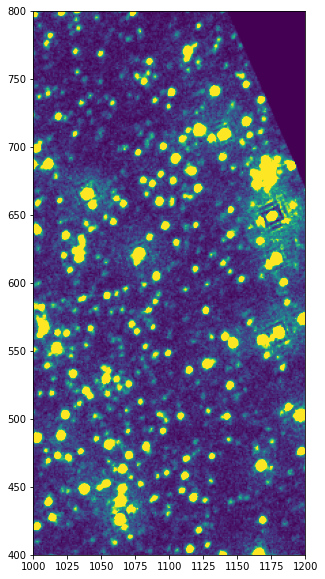

In [28]:
plot_file(40416,xdim=[1000,1200],ydim=[400,800])

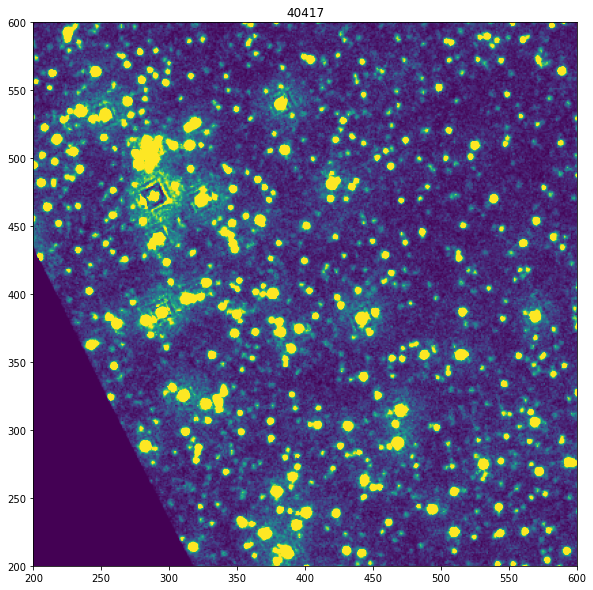

In [21]:
plot_file(40417,xdim=[200,600],ydim=[200,600])

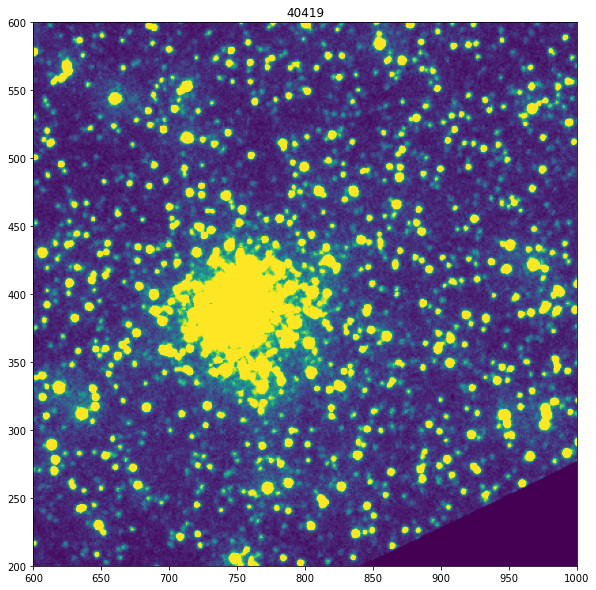

In [22]:
plot_file(40419,xdim=[600,1000],ydim=[200,600])

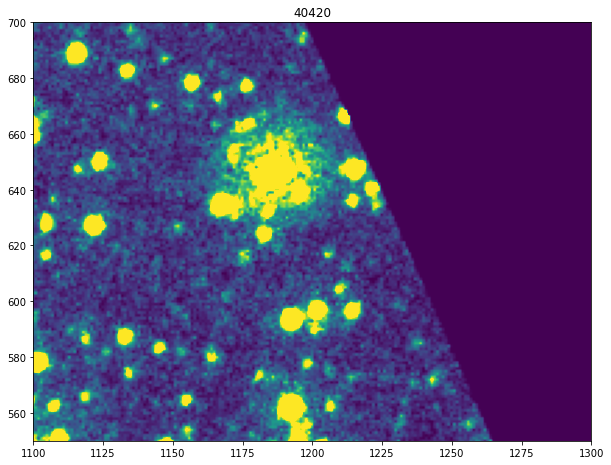

In [23]:
plot_file(40420,xdim=[1100,1300],ydim=[550,700])

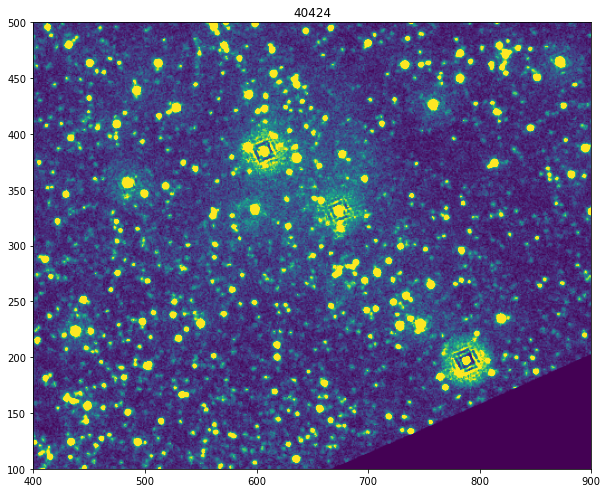

In [24]:
plot_file(40424,xdim=[400,900],ydim=[100,500])

# Idea 1: Do aperture photometry and look at highest count sources.

Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55466.000949 from DATE-OBS.
Set MJD-END to 55466.003194 from DATE-END'. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


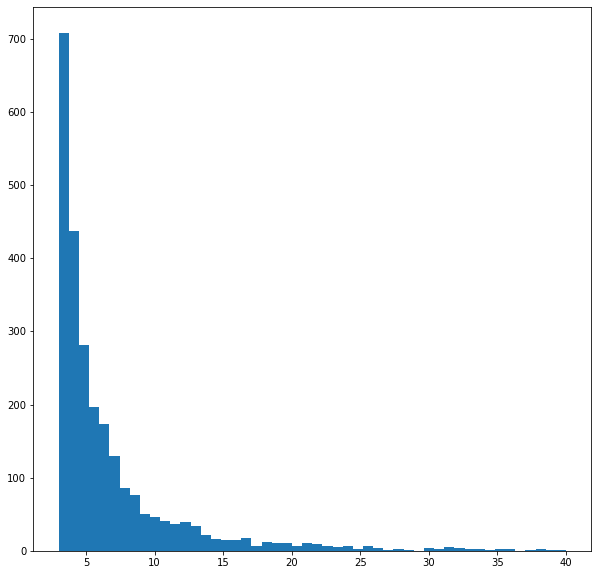

In [35]:
# Pick your favorite file
HDR,CAT,CAT_File_Name = get_file(40415)
data = HDR[0].data

# Get Photometry from Retrieve Source
r,c = np.shape(HDR[0])
meta = get_meta().with_hdu(HDR[0],
                           optical_catalog=CAT_File_Name[0],
                           xdim=[0,r],
                           ydim=[0,c])

init_phot_full = meta.source_intensities
# Remove photometry that is '0' or 'nan'
init_phot = init_phot_full[(init_phot_full != 0) & (~np.isnan(init_phot_full)) ]

# Plot a histogram of the aperture photometry values we got. 
plt.figure(figsize=(10,10))
plt.hist(init_phot,bins=50,range=(3,40));

(600.0, 800.0)

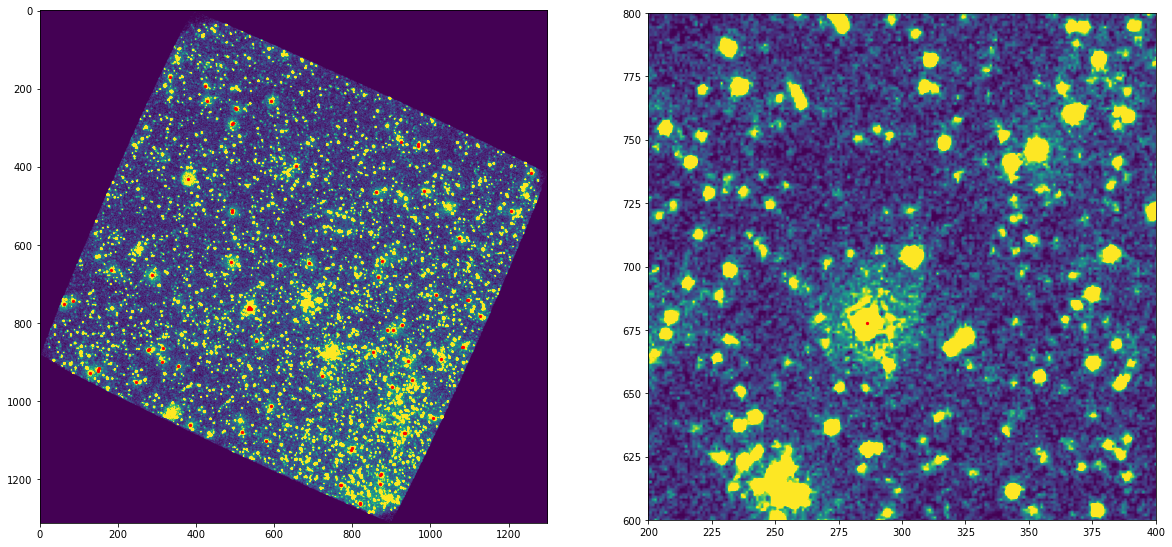

In [36]:
# Imagine in the histogram that there's some 'cutoff' for the tail, where everything above is considered 'suspish'.
# Pick a threshhold where you want to select out bright things
threshhold = 25

x,y = meta.pixel_positions
x = x[(init_phot_full != 0) & (~np.isnan(init_phot_full)) & (init_phot_full > threshhold)]
y = y[(init_phot_full != 0) & (~np.isnan(init_phot_full)) & (init_phot_full > threshhold)]

# Plot what would be removed if you went with this thresshold. 
# Two images, one zooms in on a problematic region to see if we got it.
Z = ZScaleInterval()
vmin,vmax = Z.get_limits(data)
f,axes=plt.subplots(1,2,figsize=(20,10))    
axes[0].imshow(data,vmin=vmin,vmax=vmax)
axes[1].imshow(data,vmin=vmin,vmax=vmax)
[ax.scatter(x,y,s=5,c='r') for ax in axes]
axes[1].set_xlim(200,400)
axes[1].set_ylim(600,800)